# Dataset Exploritory Analysis 

The RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) is a widely used dataset for emotion classification using recorded speech because of its high quality and consistent audio quality. The dataset can be found at https://smartlaboratory.org/ravdess/ and more info can be found in this offical citation from the creators: 

Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

RAVDESS contains both audio and video but for this project i will only be using and discussions the audio-only portion of the dataset. The database contains audio from 24 actors (12 male, 12 female) each speaking 2 similar sentences in a neutral North American accent. Each statement is spoken in 8 different emotions/ expressions (calm, happy, sad, angry, fearful, suprise, and disgust). Each one is performed in 2 different levels of emotional intensity (normal, strong) and a neutral expression is added. All audio recordings have a sample rate of 48kHz with a bit depth of 16bit. There is a total of 1440 audio files (24 actors X 60 trials per actor).


RAVDESS does not come with any sort of metadata table with information on the recordings but instead the filename themselves have all the information. Each filename has a 7 part numerical identifier (ex. 03-01-04-01-01-02-12.wav). The identifiers represent the following: 

    1.) Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    2.) Vocal channel (01 = speech, 02 = song).
    3.) Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    4.) Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
    5.) Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
    6.) Repetition (01 = 1st repetition, 02 = 2nd repetition).
    7.) Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So for example the file 03-01-04-01-01-02-12.wav contains the following metadata: 

    1.) Audio-only (03)
    2.) Speech (01)
    3.) Sad (04)
    4.) Normal Intensity (01)
    5.) "Kids are talking by the door" (01)
    6.) Second Repetition (02)
    7.) Actor-12 Male (12) 

In [1]:
import numpy as np 
import pandas as pd
import os 
import math
import torch 
import torchaudio 
import matplotlib.pyplot as plt 
#%matplotlib_inline
import seaborn as sns
import librosa 
import librosa.display

import IPython.display as ipd


# Creating Metadata table

To make the audio data easier to deal with I will create a Pandas data frame that will contain the file path of each audio file and linked to it's emotion as it will be are target variable. The audio files are each separated into their own folders by which actor performed them. 

In [2]:
Ravdess = '/Users/stephen/Emotion_Detection-/data/RAVDESS/'

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
1,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
2,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
3,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
4,disgust,/Users/stephen/Emotion_Detection-/data/RAVDESS...


In [3]:
# Lets take a look at our target variables 
Ravdess_df['Emotions'].value_counts()

angry       192
fear        192
disgust     192
sad         192
surprise    192
happy       192
calm        192
neutral      96
Name: Emotions, dtype: int64

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


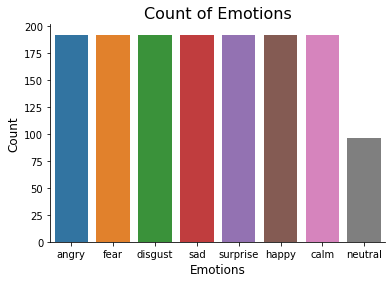

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

The Dataset is all balanced except for the "neutral" emotion. This doesn't seem like it will be a problem so we'll leave it as is for now. 

# Visualizing the audio data
Here we'll use the Pytorch module torchaudio to convert the .wav files to tensor object so we can visualize the signal and then perform the necessary feature extractions to obtain data to train our model. 

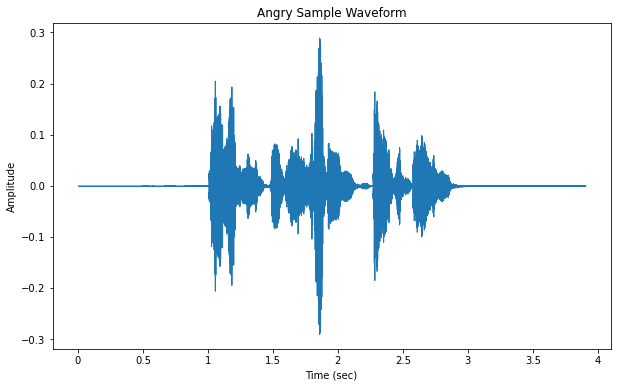

In [5]:
# declare a variable that will locate a wav file to extract from 
angry_file_row = Ravdess_df.loc[Ravdess_df['Emotions'] == 'angry']
test_file_row = angry_file_row.iloc[0]
test_file_row

y, sr = librosa.load(test_file_row['Path'])
ipd.Audio(y, rate=sr)
# visualize waveform
fig, ax = plt.subplots(figsize=(10,6))
librosa.display.waveshow(y, sr=sr, ax=ax);
ax.set(title='Angry Sample Waveform', xlabel='Time (sec)', ylabel='Amplitude');

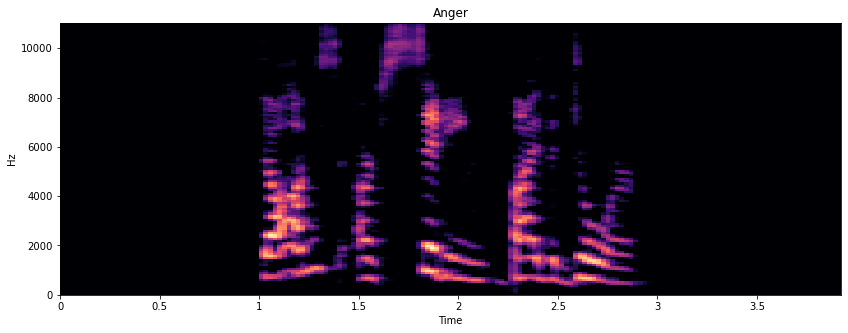

In [6]:

# mellllllsss
mel = librosa.feature.melspectrogram(y)
mel_db = librosa.amplitude_to_db(mel)
plt.figure(figsize=(14, 5))
plt.title('Anger')
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='hz')

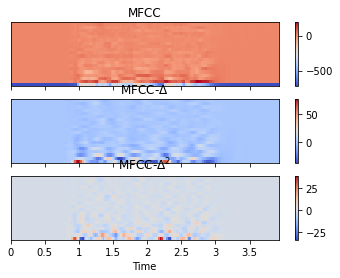

In [7]:
test_mfcc = librosa.feature.mfcc(y=y, sr=sr)
test_mfcc_delta = librosa.feature.delta(test_mfcc)
test_mfcc_delta2 = librosa.feature.delta(test_mfcc, order=2)


fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img1 = librosa.display.specshow(test_mfcc, ax=ax[0], x_axis='time')
ax[0].set(title='MFCC')
ax[0].label_outer()
img2 = librosa.display.specshow(test_mfcc_delta, ax=ax[1], x_axis='time')
ax[1].set(title=r'MFCC-$\Delta$')
ax[1].label_outer()
img3 = librosa.display.specshow(test_mfcc_delta2, ax=ax[2], x_axis='time')
ax[2].set(title=r'MFCC-$\Delta^2$')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])
fig.colorbar(img3, ax=[ax[2]])

In [8]:
Ravdess_df.set_index('Path', inplace=True)
Ravdess_df

,Emotions
Path,
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_16/03-01-05-01-02-01-16.wav,angry
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_16/03-01-06-01-02-02-16.wav,fear
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_16/03-01-06-02-01-02-16.wav,fear
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_16/03-01-05-02-01-01-16.wav,angry
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_16/03-01-07-01-01-01-16.wav,disgust
...,...
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_08/03-01-03-02-02-02-08.wav,happy
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_08/03-01-03-01-01-02-08.wav,happy
/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_08/03-01-02-02-01-01-08.wav,calm


# Visually Comparing the Different Classes

In [9]:
# Visually Comparing the Different Classes

In [10]:
# visually compaing all emotions 

hop_length = 512

angry_vis = Ravdess_df.loc[Ravdess_df.Emotions=='angry'].index[0]
angry_sig, sr = librosa.load(angry_vis, sr=16000, duration=2.5, offset=0.6)
#angry_mel = librosa.feature.melspectrogram(librosa.power_to_db(angry_sig, ref=np.max))
angry_spec = librosa.amplitude_to_db(np.abs(librosa.stft(angry_sig, hop_length=hop_length)), ref=np.max)

fear_vis = Ravdess_df.loc[Ravdess_df.Emotions=='fear'].index[0]    
fear_sig, sr = librosa.load(fear_vis, sr=16000, duration=2.5, offset=0.6)
#fear_mel = librosa.feature.melspectrogram(librosa.power_to_db(fear_sig, ref=np.max))
fear_spec = librosa.amplitude_to_db(np.abs(librosa.stft(fear_sig, hop_length=hop_length)), ref=np.max)

disgust_vis = Ravdess_df.loc[Ravdess_df.Emotions=='disgust'].index[0]  
disgust_sig, sr = librosa.load(disgust_vis, sr=16000, duration=2.5, offset=0.6)
#disgust_mel = librosa.feature.melspectrogram(librosa.power_to_db(disgust_sig, ref=np.max))
disgust_spec = librosa.amplitude_to_db(np.abs(librosa.stft(disgust_sig, hop_length=hop_length)), ref=np.max)

sad_vis = Ravdess_df.loc[Ravdess_df.Emotions=='sad'].index[0]
sad_sig, sr = librosa.load(sad_vis, sr=16000, duration=2.5, offset=0.6)
#sad_mel = librosa.feature.melspectrogram(librosa.power_to_db(sad_sig, ref=np.max))
sad_spec = librosa.amplitude_to_db(np.abs(librosa.stft(sad_sig, hop_length=hop_length)), ref=np.max)

surprise_vis = Ravdess_df.loc[Ravdess_df.Emotions=='surprise'].index[0]
surprise_sig, sr = librosa.load(surprise_vis, sr=16000, duration=2.5, offset=0.6)
#surprise_mel = librosa.feature.melspectrogram(librosa.power_to_db(surprise_sig, ref=np.max))
surprise_spec = librosa.amplitude_to_db(np.abs(librosa.stft(surprise_sig, hop_length=hop_length)), ref=np.max)

happy_vis = Ravdess_df.loc[Ravdess_df.Emotions=='happy'].index[0]      
happy_sig, sr = librosa.load(happy_vis, sr=16000, duration=2.5, offset=0.6)
#happy_mel = librosa.feature.melspectrogram(librosa.power_to_db(happy_sig, ref=np.max))
happy_spec = librosa.amplitude_to_db(np.abs(librosa.stft(happy_sig, hop_length=hop_length)), ref=np.max)

calm_vis = Ravdess_df.loc[Ravdess_df.Emotions=='calm'].index[0]       
calm_sig, sr = librosa.load(calm_vis, sr=16000, duration=2.5, offset=0.6)
#calm_mel = librosa.feature.melspectrogram(librosa.power_to_db(calm_sig, ref=np.max))
calm_spec = librosa.amplitude_to_db(np.abs(librosa.stft(calm_sig, hop_length=hop_length)), ref=np.max)

neutral_vis = Ravdess_df.loc[Ravdess_df.Emotions=='neutral'].index[0]
neutral_sig, sr = librosa.load(neutral_vis, sr=16000, duration=2.5, offset=0.6)
#neutral_mel = librosa.feature.melspectrogram(librosa.power_to_db(neutral_sig, ref=np.max))
neutral_spec = librosa.amplitude_to_db(np.abs(librosa.stft(neutral_sig, hop_length=hop_length)), ref=np.max)

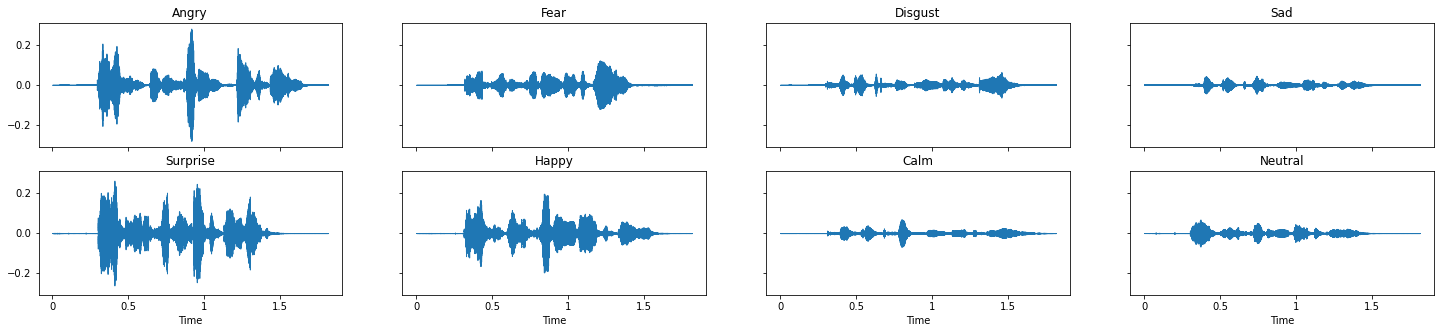

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 5), sharex=True, sharey=True)
ax = ax.ravel()

img1 = librosa.display.waveshow(angry_sig, ax=ax[0])
ax[0].set(title='Angry')
ax[0].label_outer()

img2 = librosa.display.waveshow(fear_sig, ax=ax[1])
ax[1].set(title='Fear')
ax[1].label_outer()

img3 = librosa.display.waveshow(disgust_sig, ax=ax[2])
ax[2].set(title='Disgust')
ax[2].label_outer()

img4 = librosa.display.waveshow(sad_sig, ax=ax[3])
ax[3].set(title='Sad')
ax[3].label_outer()

img5 = librosa.display.waveshow(surprise_sig, ax=ax[4])
ax[4].set(title='Surprise')
ax[4].label_outer()

img6 = librosa.display.waveshow(happy_sig, ax=ax[5])
ax[5].set(title='Happy')
ax[5].label_outer()

img7 = librosa.display.waveshow(calm_sig, ax=ax[6])
ax[6].set(title='Calm')
ax[6].label_outer()

img8 = librosa.display.waveshow(neutral_sig, ax=ax[7])
ax[7].set(title='Neutral')
ax[7].label_outer()

fig.savefig('Emotion Classes')

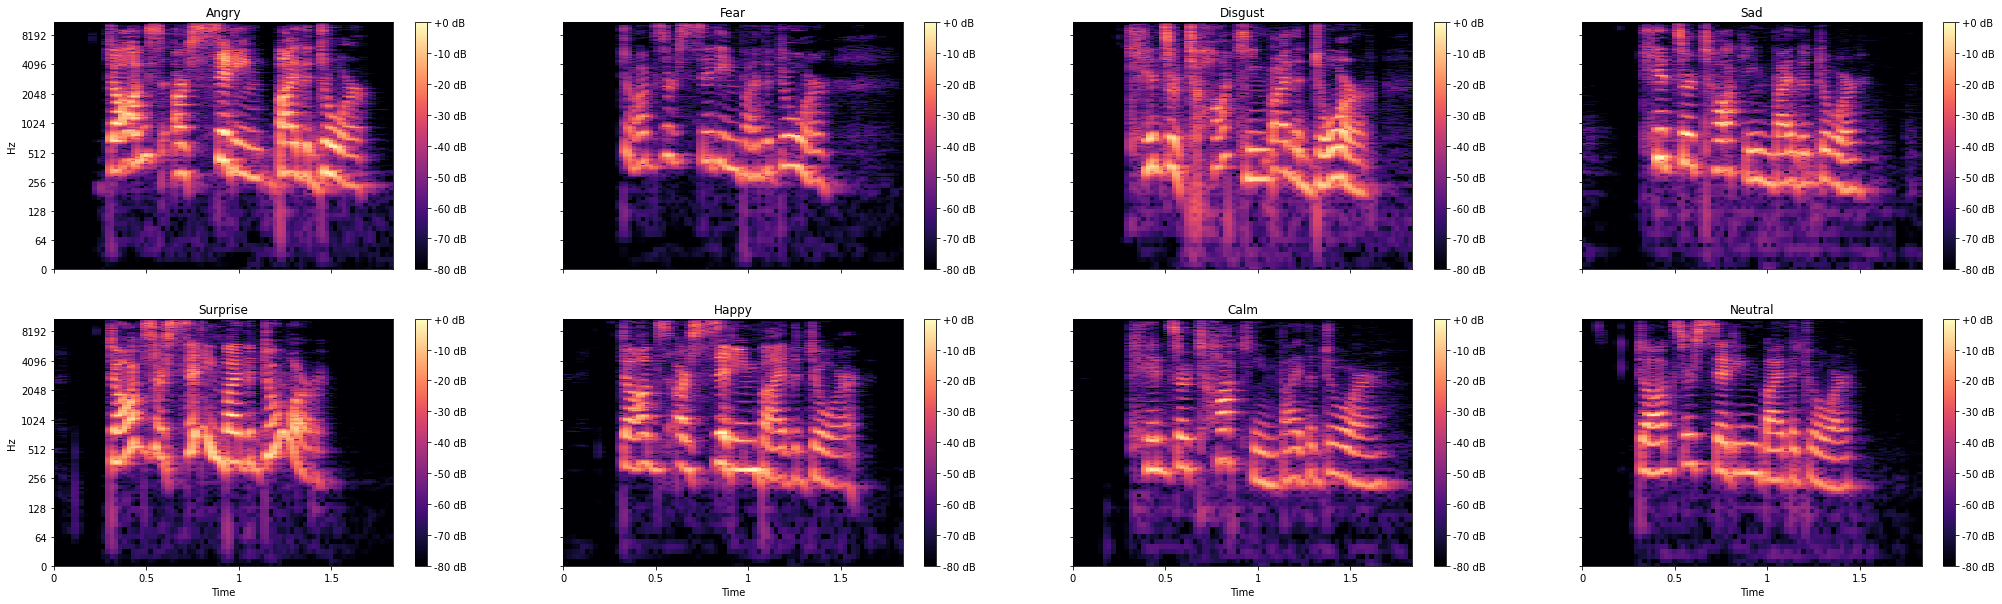

In [12]:
# Spectrograms 

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(35, 10), sharex=True, sharey=True)
ax = ax.ravel()

img1 = librosa.display.specshow(angry_spec, ax=ax[0], x_axis='time', y_axis='log')
ax[0].set(title='Angry')
ax[0].label_outer()

img2 = librosa.display.specshow(fear_spec, ax=ax[1], x_axis='time', y_axis='log')
ax[1].set(title='Fear')
ax[1].label_outer()

img3 = librosa.display.specshow(disgust_spec, ax=ax[2], x_axis='time', y_axis='log')
ax[2].set(title='Disgust')
ax[2].label_outer()

img4 = librosa.display.specshow(sad_spec, ax=ax[3], x_axis='time', y_axis='log')
ax[3].set(title='Sad')
ax[3].label_outer()

img5 = librosa.display.specshow(surprise_spec, ax=ax[4], x_axis='time', y_axis='log')
ax[4].set(title='Surprise')
ax[4].label_outer()

img6 = librosa.display.specshow(happy_spec, ax=ax[5], x_axis='time', y_axis='log')
ax[5].set(title='Happy')
ax[5].label_outer()

img7 = librosa.display.specshow(calm_spec, ax=ax[6], x_axis='time', y_axis='log')
ax[6].set(title='Calm')
ax[6].label_outer()

img8 = librosa.display.specshow(neutral_spec, ax=ax[7], x_axis='time', y_axis='log')
ax[7].set(title='Neutral')
ax[7].label_outer()

fig.colorbar(img1, ax=[ax[0]], format="%+2.f dB")
fig.colorbar(img2, ax=[ax[1]], format="%+2.f dB")
fig.colorbar(img3, ax=[ax[2]], format="%+2.f dB")
fig.colorbar(img4, ax=[ax[3]], format="%+2.f dB")
fig.colorbar(img5, ax=[ax[4]], format="%+2.f dB")
fig.colorbar(img6, ax=[ax[5]], format="%+2.f dB")
fig.colorbar(img7, ax=[ax[6]], format="%+2.f dB")
fig.colorbar(img8, ax=[ax[7]], format="%+2.f dB")


As you can see different emotions have different tonal qualities. From looking at the overall amplitude over time we can see that some emotions like Anger, Happy, and Surprise are generally louder than some other emotions like Sad and Disgust.  

# Data Augmentation 
It is common practice to transform audio data with data augmentation tools like time adding white noise, time-stretching and pitch shifts. 
We'll make duplicates of each wav file so our model will have more variable input data. 

In [13]:
rand = '/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_09/03-01-05-02-01-02-09.wav'
augment, sr = librosa.load(rand, sr=16000)
print('Anger, Srong, Male')
ipd.Audio(augment, rate=sr)

Anger, Srong, Male


In [14]:
def noise(data, SNR=20):   # https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8
    RMS_s = math.sqrt(np.mean(data**2))
    # RMS values of noise 
    RMS_n = math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    # using population formula for standard daviation 
    # mean = 0 STD = RMS
    STD_n = RMS_n 
    noise = np.random.normal(0, STD_n, data.shape[0])
    new_data = data + noise
    return noise

print('Noise')
d = noise(augment)
ipd.Audio(d, rate=sr)

Noise


In [15]:
print('Noise plus original signal')
ipd.Audio(d + augment, rate=sr)

Noise plus original signal


Now we'll try streching out audio in the time domain. First lets see what slowing down the audio so its playing 50% slower

In [16]:
print('Stretched at half speed')
slowed_down = librosa.effects.time_stretch(augment, rate=.50)
ipd.Audio(slowed_down, rate=sr)

Stretched at half speed


and now doubling the speed

In [17]:
print('Stretched at double speed')
speed_up = librosa.effects.time_stretch(augment, rate=2)
ipd.Audio(speed_up, rate=sr)

Stretched at double speed


Both are done purely for example purposes because both are to extreme to be of any actual use in a prediction model. Something slowed down to 3/4 is more feesable.

In [18]:
print('Slowed to 3/4')
three_forths = librosa.effects.time_stretch(augment, rate=.75)
ipd.Audio(three_forths, rate=sr)

Slowed to 3/4


Still sounds a little weird and there's deffinantly some phase issues going on so lets try pitch shifting. and just for a refreshers here's our original test signal. 

In [19]:
augment, sr = librosa.load(rand, sr=16000)
print('Anger, Srong, Male')
ipd.Audio(augment, rate=sr)

Anger, Srong, Male


In [20]:
# pitch shifting up a major third 
third_up = librosa.effects.pitch_shift(augment, sr=16000, n_steps=4)
ipd.Audio(third_up, rate=sr)

In [21]:
# pitch shifting up a major third 
third_down = librosa.effects.pitch_shift(augment, sr=16000, n_steps=-4)
ipd.Audio(third_down, rate=sr)

In [22]:
three_qt = librosa.effects.pitch_shift(augment, sr, n_steps=3,
                                         bins_per_octave=24)
ipd.Audio(three_qt, rate=sr)

Using time stretching and pitch stretching in combination and return some interesting results 

In [23]:
slowed_pitched_up = librosa.effects.pitch_shift(three_forths, sr=16000, n_steps=3, bins_per_octave=24)
ipd.Audio(slowed_pitched_up, rate=sr)

Next is my experimental Data Augmentation technique and I use the word "experimantal" because I havent seen this method used much and really only mentioned in research papers so I thought it would be fun to try out. The method is called Pre-Emphasis. More info can be found here:    https://wiki.aalto.fi/display/ITSP/Pre-emphasis

In [24]:
pre_emp = librosa.effects.preemphasis(augment, coef=0.97)
ipd.Audio(pre_emp, rate=sr)

Pre-emphasis gives a boost to the higher frequencies that sometimes get lost in some transformations used in preprocessing.  

# Conclusion 
So we can take these data augmentation functions and create synthetic audio data to better train the model. Speech Recognition can be difficult because of the differences in human voices and speech. With Data augmentation we can sort of simulate this idea and create unique audio data that can help train the model. This combined with the different feature extractions will provide enough information to predict emotions with recorded speech data. 